In [296]:
import pandas as pd
import json
import numpy as np
from itertools import chain
from collections import defaultdict
from enum import Enum
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.ticker import MaxNLocator

# Participation details

Here we show some basic information about participants in the study.

In [297]:
df = pd.read_csv("participation.csv")

In [298]:
age_map = {
     0: "0-15",
    16: "16-20",
    21: "21-30",
    29: "31-40",
    41: "41-50",
    51: "51-65",
    65: "65+"
}

gender_map = {
     0: "male",
     1: "female",
     2: "other"
}

## Age groups

In [299]:
df["age_group_label"] = df["age_group"].replace(age_map)

# Preserve the original bin order (so 0‑15 appears first, 65+ last)
cat_order = list(age_map.values())
df["age_group_label"] = pd.Categorical(df["age_group_label"], ordered=True, categories=cat_order)

age_counts = df["age_group_label"].value_counts().sort_index()
age_counts.to_frame("count")

,count
age_group_label,
0-15,0
16-20,1
21-30,18
31-40,18
41-50,8
51-65,6
65+,2


## Gender counts

In [300]:
df["gender_label"] = df["gender"].replace(gender_map)
gender_counts = df["gender_label"].value_counts().reindex(gender_map.values(), fill_value=0)
gender_counts.to_frame("count")

,count
gender_label,
male,36
female,17
other,0


## Average completion time

In [301]:
df["time_joined"]   = pd.to_datetime(df["time_joined"])
df["time_finished"] = pd.to_datetime(df["time_finished"])

durations = df["time_finished"] - df["time_joined"]
mean_dur  = durations.mean()

# Convert to mm:ss
mean_minutes, mean_seconds = divmod(int(mean_dur.total_seconds()), 60)
avg_time_str = f"{mean_minutes}:{mean_seconds:02d}"

print(f"Average study duration: {avg_time_str} (mm:ss)")

Average study duration: 8:30 (mm:ss)


# User study interactions

Now we will analyze user feedback and interactions from the diversity perception phase and recommendation phase of the study.



## Diversity perception phase

`diversity-perception-ended` interaction_type

Data:

```json

{
  "sim_plot": [
    {
      "rating": integer,
      "genre_sim": number,
      "plot_sim": number 
    }
    // ... 
  ],
  "sim_genres": [
      { 
      "rating": integer,
      "genre_sim": number,
      "plot_sim": number
    }
    // ... 
  ],
  "attention_check": [ 
      {
      "rating": integer,
      "genre_sim": number, 
      "plot_sim": number
    }
    // ... 
  ],
}


```

In [302]:
df_int = pd.read_csv("interaction.csv")

div_df = df_int[df_int["interaction_type"] == "diversity-perception-ended"].copy()

# If a participant somehow produced more than one such row we keep last one
div_df.sort_values("time", inplace=True)
div_df = div_df.drop_duplicates("participation", keep="last")
div_df.head(5)

,id,participation,interaction_type,time,data
0,1,1,diversity-perception-ended,2025-07-13 15:46:27.664147,"{""sim_plot"": [{""rating"": 1, ""genre_sim"": 0.430..."
145,146,2,diversity-perception-ended,2025-07-13 16:18:50.345352,"{""sim_genres"": [{""rating"": 1, ""genre_sim"": 0.8..."
182,183,3,diversity-perception-ended,2025-07-13 16:20:47.828437,"{""sim_genres"": [{""rating"": 5, ""genre_sim"": 0.8..."
191,192,4,diversity-perception-ended,2025-07-13 16:21:01.317508,"{""sim_genres"": [{""rating"": 3, ""genre_sim"": 0.8..."
514,515,5,diversity-perception-ended,2025-07-13 16:26:07.932201,"{""sim_genres"": [{""rating"": 3, ""genre_sim"": 0.8..."


In [303]:
def fails_attention_check(json_blob):
    d = json.loads(json_blob)
    att = d.get("attention_check", [])
    return all(item["rating"] > 3 for item in att)

fail_mask = div_df["data"].apply(fails_attention_check)

print("Participants failing the attention check (rating > 3):")
display(div_df.loc[fail_mask])
fail_participation_ids = div_df.loc[fail_mask, 'participation'].unique()
print(fail_participation_ids)
# Drop those rows 
div_df = div_df[~fail_mask].reset_index(drop=True)

Participants failing the attention check (rating > 3):


,id,participation,interaction_type,time,data
182,183,3,diversity-perception-ended,2025-07-13 16:20:47.828437,"{""sim_genres"": [{""rating"": 5, ""genre_sim"": 0.8..."
2472,2473,23,diversity-perception-ended,2025-07-14 08:08:01.713389,"{""sim_genres"": [{""rating"": 5, ""genre_sim"": 0.8..."
4571,4572,39,diversity-perception-ended,2025-07-14 10:21:42.976832,"{""sim_plot"": [{""rating"": 3, ""genre_sim"": 0.410..."
6133,6134,52,diversity-perception-ended,2025-07-14 11:29:17.327109,"{""sim_plot"": [{""rating"": 5, ""genre_sim"": 0.395..."


[ 3 23 39 52]


In [304]:
class DiversityStimulus(str, Enum):
    GENRES = "genres"
    PLOT = "plot"

def rating_to_directional_effect(rating):
    """
    Convert rating to effect:
    - 1 or 2 -> user thinks movies are similar → +delta
    - 4 or 5 -> user thinks movies are diverse → -delta
    - 3 → neutral, no effect
    """
    if rating in (1, 2):
        return 1
    elif rating in (4, 5):
        return -1
    else:
        return 0

def compute_pair_deltas(pairs):
    """
    Compute signed delta for each pair based on plot_sim and genre_sim.
    Positive delta if plot_sim > genre_sim (push toward plot),
    negative if genre_sim > plot_sim (push toward genre).
    """
    deltas = []
    for pair in pairs:
        plot_sim = float(pair['plot_sim'])
        genre_sim = float(pair['genre_sim'])
        diff = abs(plot_sim - genre_sim)
        direction = 1 if plot_sim > genre_sim else -1
        deltas.append(direction * diff)
    return deltas

def compute_stimulus_score(div_perception):
    """
    Given the diversity perception data JSON (dict),
    compute total stimulus score as sum of rating effect * delta,
    return numeric score and final stimulus type label.
    """
    all_pairs = div_perception.get('sim_genres', []) + div_perception.get('sim_plot', [])
    ratings = [int(item['rating']) for item in all_pairs]

    deltas = compute_pair_deltas(all_pairs)

    stimulus_score = 0.0
    for delta, rating in zip(deltas, ratings):
        effect = rating_to_directional_effect(rating)
        stimulus_score += effect * delta

    stimulus_label = DiversityStimulus.PLOT if stimulus_score >= 0 else DiversityStimulus.GENRES
    return stimulus_score, stimulus_label.value

def apply_stimulus(row):
    data_json = json.loads(row['data'])
    score, label = compute_stimulus_score(data_json)
    return pd.Series({"stimulus_score": score, "stimulus_label": label})

div_df[['stimulus_score', 'stimulus_label']] = div_df.apply(apply_stimulus, axis=1)

def extract_plot_genres_avg(json_blob):
    d = json.loads(json_blob)
    sim_plot = d.get("sim_plot", [])
    sim_genres = d.get("sim_genres", [])
    sim_plot_avg = np.mean([item["rating"] for item in sim_plot])
    sim_genres_avg = np.mean([item["rating"] for item in sim_genres])
    return pd.Series({"sim_plot_avg": sim_plot_avg, "sim_genres_avg": sim_genres_avg})

div_df[['sim_plot_avg', 'sim_genres_avg']] = div_df['data'].apply(extract_plot_genres_avg)

div_df.head(5)

,id,participation,interaction_type,time,data,stimulus_score,stimulus_label,sim_plot_avg,sim_genres_avg
0,1,1,diversity-perception-ended,2025-07-13 15:46:27.664147,"{""sim_plot"": [{""rating"": 1, ""genre_sim"": 0.430...",2.123412,plot,1.333333,4.000000
1,146,2,diversity-perception-ended,2025-07-13 16:18:50.345352,"{""sim_genres"": [{""rating"": 1, ""genre_sim"": 0.8...",-0.634237,genres,1.333333,1.333333
2,192,4,diversity-perception-ended,2025-07-13 16:21:01.317508,"{""sim_genres"": [{""rating"": 3, ""genre_sim"": 0.8...",0.133235,plot,3.000000,3.000000
3,515,5,diversity-perception-ended,2025-07-13 16:26:07.932201,"{""sim_genres"": [{""rating"": 3, ""genre_sim"": 0.8...",-1.009455,genres,4.666667,3.000000
4,567,6,diversity-perception-ended,2025-07-13 16:32:12.875247,"{""sim_genres"": [{""rating"": 4, ""genre_sim"": 0.8...",0.555714,plot,4.666667,4.000000


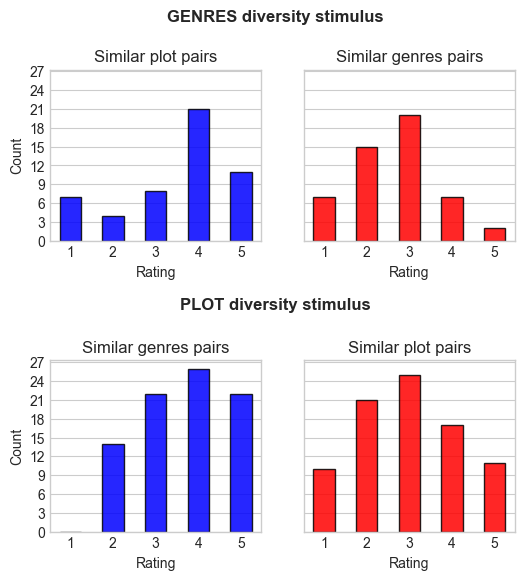

In [305]:
plt.style.use("seaborn-v0_8-whitegrid")

genres_df = div_df[div_df['stimulus_label'] == "genres"].copy()
plot_df = div_df[div_df['stimulus_label'] == "plot"].copy()

# Extract ratings for genres stimulus
plot_ratings_genres = []
genre_ratings_genres = []

for data in genres_df['data']:
    parsed = json.loads(data)
    plot_ratings_genres += [int(item['rating']) for item in parsed.get("sim_plot", [])]
    genre_ratings_genres += [int(item['rating']) for item in parsed.get("sim_genres", [])]

plot_counts_genres = Counter(plot_ratings_genres)
genre_counts_genres = Counter(genre_ratings_genres)

# Extract ratings for plot stimulus
plot_ratings_plot = []
genre_ratings_plot = []

for data in plot_df['data']:
    parsed = json.loads(data)
    plot_ratings_plot += [int(item['rating']) for item in parsed.get("sim_plot", [])]
    genre_ratings_plot += [int(item['rating']) for item in parsed.get("sim_genres", [])]

plot_counts_plot = Counter(plot_ratings_plot)
genre_counts_plot = Counter(genre_ratings_plot)

# Create the plots
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True, gridspec_kw={'hspace': 0.7})
for ax in axes.flat:
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(axis='x', visible=False)

bar_width = 0.5  # thinner bars
bar_style = dict(alpha=0.85, edgecolor='black')

# GENRES stimulus
axes[0, 0].bar(range(1, 6), [plot_counts_genres.get(i, 0) for i in range(1, 6)],
               color='blue', width=bar_width, **bar_style)
axes[0, 0].set_title('Similar plot pairs')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_xticks(range(1, 6))

axes[0, 1].bar(range(1, 6), [genre_counts_genres.get(i, 0) for i in range(1, 6)],
               color='red', width=bar_width, **bar_style)
axes[0, 1].set_title('Similar genres pairs')
axes[0, 1].set_xlabel('Rating')
axes[0, 1].set_xticks(range(1, 6))

# PLOT stimulus
axes[1, 0].bar(range(1, 6), [genre_counts_plot.get(i, 0) for i in range(1, 6)],
               color='blue', width=bar_width, **bar_style)
axes[1, 0].set_title('Similar genres pairs')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xlabel('Rating')
axes[1, 0].set_xticks(range(1, 6))

axes[1, 1].bar(range(1, 6), [plot_counts_plot.get(i, 0) for i in range(1, 6)],
               color='red', width=bar_width, **bar_style)
axes[1, 1].set_title('Similar plot pairs')
axes[1, 1].set_xlabel('Rating')
axes[1, 1].set_xticks(range(1, 6))

fig.text(0.5, 0.96, "GENRES diversity stimulus", ha='center', fontsize=12, weight='bold')
fig.text(0.5, 0.48, "PLOT diversity stimulus", ha='center', fontsize=12, weight='bold')

plt.show()

## Genre diversity stimulus

If the user diversity stimulus is determined to be GENRES:  
- movies with similar plots and different genres are on average ***3.38***
- movies with similar genres and different plots are on average ***2.64***

## Plot diversity stimulus
If the user diversity stimulus is determined to be PLOT:
- movies with similar plots and different genres are on average ***2.96***
- movies with similar genres and different plots are on average ***3.65***


We see that diversity ratings of pairs with similar genres of users whose stimulus was determined to be GENRES (2.64) is lower than diversity ratings of pairs with similar plots of users whose stimulus was determined to be PLOT (2.96). 

This indicates that users who focus on genres see similar genre pairs as less diverse and their perception matches the similarity of embeddings more than users who focus on plots.

In [306]:
grouped_avgs = div_df.groupby("stimulus_label")[["sim_plot_avg", "sim_genres_avg"]].mean()
grouped_avgs


,sim_plot_avg,sim_genres_avg
stimulus_label,,
genres,3.490196,2.647059
plot,2.976190,3.666667


In [307]:
counts = div_df['stimulus_label'].value_counts()
counts.to_frame("count")


,count
stimulus_label,
plot,28
genres,17


In [308]:
max_score = div_df['stimulus_score'].max()
min_score = div_df['stimulus_score'].min()
print(f"Max stimulus score (PLOT): {max_score}")
print(f"Min stimulus score (GENRES): {min_score}")


Max stimulus score (PLOT): 2.6540644466876984
Min stimulus score (GENRES): -2.890048399567604


In [309]:
score_stats = (
    div_df
      .groupby("stimulus_label")["stimulus_score"]
      .agg(
          mean = "mean",
          median = "median",
          std = "std"
      )
)

score_stats

,mean,median,std
stimulus_label,,,
genres,-0.869691,-0.634237,0.724617
plot,0.809983,0.667322,0.637280


## Recommendation phase

First, we will process for each user, for every iteration, for every algorithm, how many of the recommended movies were selected by the user.  
Then, we will calculate per-user totals and averages of selected movies accross all iterations.  
In the end, we will calculate overall totals and averages for each algorithm.  



In [310]:
df = pd.read_csv("interaction.csv")

# Work only with rows relevant to the recommendation phase
phase_mask = df["interaction_type"].isin(["iteration-started", "iteration-ended"])
phase_df = df[phase_mask].copy()
phase_df = phase_df[~phase_df['participation'].isin(fail_participation_ids)].reset_index(drop=True)

phase_df["data_json"] = phase_df["data"].apply(json.loads)

# Extract the iteration number
phase_df["iteration_no"] = phase_df["data_json"].apply(lambda d: d.get("iteration"))

In [311]:
starts_df = phase_df[phase_df["interaction_type"] == "iteration-started"]
ends_df = phase_df[phase_df["interaction_type"] == "iteration-ended"]

# Keep only necessary columns
starts_df = starts_df[["participation", "iteration_no", "data_json"]]
ends_df = ends_df[["participation", "iteration_no", "data_json"]]

In [312]:
starts_dict = defaultdict(dict)
for _, row in starts_df.iterrows():
    it = row["iteration_no"]
    shown = row["data_json"]["shown"]
    for algo, shown_lists in shown.items():
        if it not in starts_dict[row["participation"]]:
            starts_dict[row["participation"]][it] = {}
        starts_dict[row["participation"]][it][algo] = shown_lists[-1] # for each algo we have a list of shown movies for each iteration (also previos ones) so we get the last one

ends_dict = defaultdict(dict)
for _, row in ends_df.iterrows():
    it = row["iteration_no"]
    data = row["data_json"]
    ratings_obj = data["ratings"][-1]

    ends_dict[row["participation"]][it] = {
        "selected": data["selected"][-1], # iteration-ended contains also previous iteration data, get the last one
        "ratings": ratings_obj
    }


In [313]:
valid_participants = [
    p for p in starts_dict
    if p in ends_dict and starts_dict[p].keys() == ends_dict[p].keys()
]

print(f"Keeping {len(valid_participants)} valid participants.")

Keeping 43 valid participants.


In [314]:
iteration_data = []

for p in valid_participants:
    for it in sorted(starts_dict[p]):
        shown_dict = starts_dict[p][it] # {algo: [id, id...], algo2: [id, id...]}
        selected = set(ends_dict[p][it]["selected"])   # movie_ids the user picked
        ratings = ends_dict[p][it]["ratings"] # {algo: {relevance, diversity}}

        for algo, shown_movies in shown_dict.items():
            sel_for_algo = [m for m in shown_movies if m in selected]

            rating = ratings.get(algo)

            iteration_data.append({
                "participant": p,
                "iteration": it,
                "algo": algo,
                "selected_count": len(sel_for_algo),
                "selected_movies": sel_for_algo,
                "relevance_rating": rating["relevance"],
                "diversity_rating": rating["diversity"]
            })

per_iter_df = pd.DataFrame(iteration_data)

per_iter_df['algo'] = per_iter_df['algo'].replace({
    'Method 1': 'EASE',
    'Method 2': 'EASE BinDiv',
    'Method 3': 'LLM Profiling'
})

per_iter_df.head(12)

,participant,iteration,algo,selected_count,selected_movies,relevance_rating,diversity_rating
0,1,1,EASE,4,"[6811, 8078, 4866, 8263]",5,5
1,1,1,EASE BinDiv,3,"[5154, 6646, 6811]",5,5
2,1,1,LLM Profiling,3,"[9378, 6811, 8790]",5,5
3,1,2,EASE,3,"[4897, 8784, 4079]",4,3
4,1,2,EASE BinDiv,2,"[6483, 4897]",3,5
5,1,2,LLM Profiling,5,"[7067, 6818, 9419, 8694, 5451]",5,2
6,1,3,EASE,4,"[1398, 4837, 7026, 2659]",4,3
7,1,3,EASE BinDiv,6,"[8378, 7588, 8909, 5129, 9430, 4837]",5,5
8,1,3,LLM Profiling,4,"[6588, 157, 1375, 7026]",4,3
9,2,1,EASE,1,[3585],3,3


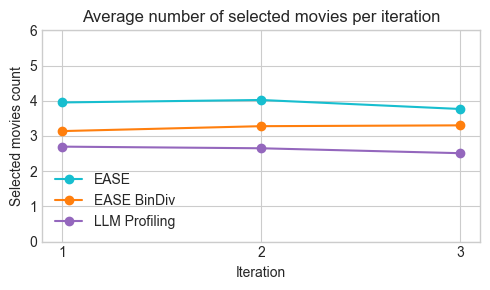

In [315]:
grouped_per_iter_selections_df = per_iter_df.groupby(['iteration', 'algo'])[['selected_count']].mean().reset_index()
grouped_per_iter_selections_df

colors = {'EASE': '#17becf',
          'EASE BinDiv': '#ff7f0e',
          'LLM Profiling': '#9467bd'}

fig, ax = plt.subplots(figsize=(5, 3))

for algo in grouped_per_iter_selections_df['algo'].unique():
    subset = grouped_per_iter_selections_df[grouped_per_iter_selections_df['algo'] == algo]
    ax.plot(subset['iteration'], subset['selected_count'], label=algo, color=colors.get(algo, 'black'), marker='o')

ax.set_title('Average number of selected movies per iteration')
ax.set_xlabel('Iteration')
ax.set_ylabel('Selected movies count')
ax.set_ylim(0, 6)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # x-axis as integers

ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

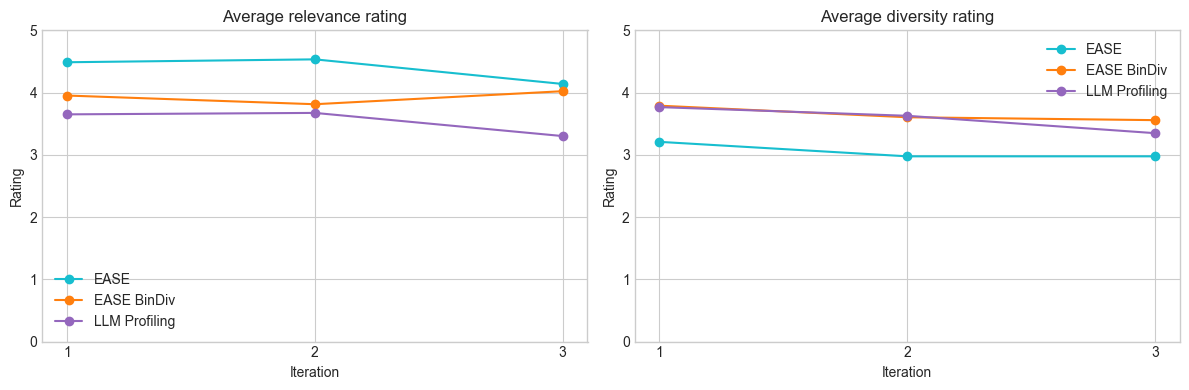

In [316]:
grouped_df = per_iter_df.groupby(['iteration', 'algo'])[['relevance_rating', 'diversity_rating']].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

for algo in grouped_df['algo'].unique():
    subset = grouped_df[grouped_df['algo'] == algo]
    axes[0].plot(subset['iteration'], subset['relevance_rating'], marker='o', 
                 label=algo, color=colors.get(algo, 'black'))
axes[0].set_title('Average relevance rating')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Rating')
axes[0].set_xticks(sorted(per_iter_df['iteration'].unique()))
axes[0].set_ylim(0, 5)
axes[0].grid(True)
axes[0].legend()

for algo in grouped_df['algo'].unique():
    subset = grouped_df[grouped_df['algo'] == algo]
    axes[1].plot(subset['iteration'], subset['diversity_rating'], marker='o', 
                 label=algo, color=colors.get(algo, 'black'))
axes[1].set_title('Average diversity rating')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Rating')
axes[1].set_xticks(sorted(per_iter_df['iteration'].unique()))
axes[1].set_ylim(0, 5)
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()



In [317]:
def union_lists(list_of_lists):
    return sorted({m for sub in list_of_lists for m in sub})

user_totals = (
    per_iter_df
      .groupby(["participant", "algo"])
      .agg(
          total_selected_count = ("selected_count", "sum"),
          avg_selected_per_iter = ("selected_count", "mean"),
          total_selected_movies = ("selected_movies", union_lists),
          avg_relevance_rating = ("relevance_rating", "mean"),
          avg_diversity_rating = ("diversity_rating", "mean")
      )
      .reset_index()
)

user_totals.head()

,participant,algo,total_selected_count,avg_selected_per_iter,total_selected_movies,avg_relevance_rating,avg_diversity_rating
0,1,EASE,11,3.666667,"[1398, 2659, 4079, 4837, 4866, 4897, 6811, 702...",4.333333,3.666667
1,1,EASE BinDiv,11,3.666667,"[4837, 4897, 5129, 5154, 6483, 6646, 6811, 758...",4.333333,5.000000
2,1,LLM Profiling,12,4.000000,"[157, 1375, 5451, 6588, 6811, 6818, 7026, 7067...",4.666667,3.333333
3,2,EASE,6,2.000000,"[2963, 3585, 4352, 5135, 6476, 6563]",3.000000,3.000000
4,2,EASE BinDiv,6,2.000000,"[2505, 3585, 5280, 5696, 6476, 6563]",2.666667,3.000000


In [318]:
overall_totals = (
    per_iter_df
      .groupby("algo")
      .agg(
          total_selected_across_users = ("selected_count", "sum"),
          avg_selected_per_user = ("selected_count", "mean"),
          avg_relevance_rating = ("relevance_rating", "mean"),
          avg_diversity_rating = ("diversity_rating", "mean")
      )
      .reset_index()
)

overall_totals


,algo,total_selected_across_users,avg_selected_per_user,avg_relevance_rating,avg_diversity_rating
0,EASE,505,3.914729,4.387597,3.054264
1,EASE BinDiv,418,3.240310,3.930233,3.651163
2,LLM Profiling,338,2.620155,3.542636,3.581395


In [319]:
overall_totals_sorted_selected = (
    overall_totals[["algo", "avg_selected_per_user"]]
    .sort_values("avg_selected_per_user", ascending=False)
    .reset_index(drop=True)
)

overall_totals_sorted_selected["rank"] = overall_totals_sorted_selected.index + 1
overall_totals_sorted_selected

,algo,avg_selected_per_user,rank
0,EASE,3.914729,1
1,EASE BinDiv,3.240310,2
2,LLM Profiling,2.620155,3


In [320]:
overall_totals_sorted_relevance = (
    overall_totals[["algo", "avg_relevance_rating"]]
    .sort_values("avg_relevance_rating", ascending=False)
    .reset_index(drop=True)
)

overall_totals_sorted_relevance["rank"] = overall_totals_sorted_relevance.index + 1
overall_totals_sorted_relevance

,algo,avg_relevance_rating,rank
0,EASE,4.387597,1
1,EASE BinDiv,3.930233,2
2,LLM Profiling,3.542636,3


In [321]:
overall_totals_sorted_diversity = (
    overall_totals[["algo", "avg_diversity_rating"]]
    .sort_values("avg_diversity_rating", ascending=False)
    .reset_index(drop=True)
)

overall_totals_sorted_diversity["rank"] = overall_totals_sorted_diversity.index + 1
overall_totals_sorted_diversity

,algo,avg_diversity_rating,rank
0,EASE BinDiv,3.651163,1
1,LLM Profiling,3.581395,2
2,EASE,3.054264,3
